# Chpter 1 感知机

## 1.1 从零实现 MLP（Multi-Layer Perceptron）

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

In [2]:
# 读取数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
# 设置参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [4]:
# 激活函数
def relu(X):
    return X.clamp(min=0)

In [5]:
# 定义模型
def net(X):
    X = X.reshape(-1, num_inputs)
    h = relu(X @ W1 + b1)
    return h @ W2 + b2

In [6]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

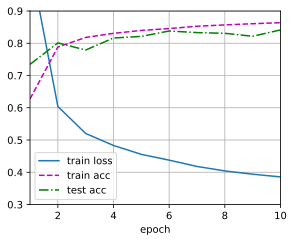

In [ ]:
# 训练模型
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

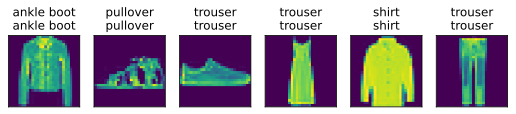

In [9]:
d2l.predict_ch3(net, test_iter, n=10)

In [18]:
# 查看训练集数据的第1个batch
X = train_iter.dataset.data

## 1.2 简单实现 MLP

In [19]:
# 1 Model net
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

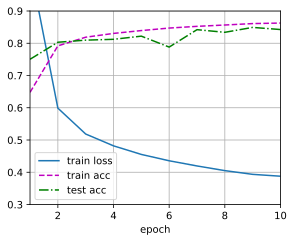

In [20]:
batch_size, lr, num_epochs = 256, 0.1, 10
# 2 Loss
loss = nn.CrossEntropyLoss(reduction='none')
# 3 Optimizer
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 0 Data
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# 4 Training
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

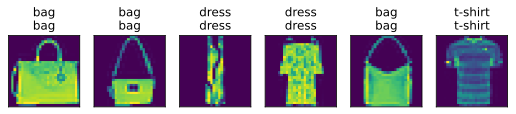

In [21]:
d2l.predict_ch3(net, test_iter, n=30)

# Chapter 2 细节注意

## 2.1 模型、过拟合、欠拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
max_degree = 20 # 多项式最大阶数
n_train, n_test = 200, 200 # 训练和测试样本数
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([4, 1.2, -3.4, 2.0]) # 真实的多项式系数

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [13]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.1943],
         [ 0.7425]]),
 tensor([[ 1.0000e+00, -1.1943e+00,  7.1313e-01, -2.8389e-01,  8.4759e-02,
          -2.0245e-02,  4.0296e-03, -6.8749e-04,  1.0263e-04, -1.3619e-05,
           1.6264e-06, -1.7658e-07,  1.7573e-08, -1.6144e-09,  1.3772e-10,
          -1.0965e-11,  8.1841e-13, -5.7494e-14,  3.8146e-15, -2.3977e-16],
         [ 1.0000e+00,  7.4250e-01,  2.7565e-01,  6.8223e-02,  1.2664e-02,
           1.8806e-03,  2.3272e-04,  2.4685e-05,  2.2910e-06,  1.8901e-07,
           1.4034e-08,  9.4729e-10,  5.8613e-11,  3.3477e-12,  1.7755e-13,
           8.7885e-15,  4.0784e-16,  1.7813e-17,  7.3478e-19,  2.8714e-20]]),
 tensor([-0.4068,  4.1269]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400, wd = 0.01):
    """训练多项式回归模型"""
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    for param in net.parameters():
        param.data.normal_()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), 
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size=batch_size, is_train=False)
    trainer = torch.optim.SGD([{'params': net[0].weight, 'weight_decay': wd}], lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 3.997622    1.2038716  -3.3857794   1.966789   -0.07455077  0.2118644
   0.25014672 -0.84949875 -0.71311456 -0.49608648  0.59725165  0.06398749
   1.5907888   0.2945797  -0.8891274   0.29962316  0.86202043 -0.15658295
  -0.18258664 -0.6114483 ]]


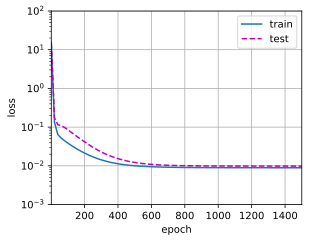

In [15]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500, wd=0.001)

weight: [[ 4.0014153   1.1549889  -3.3709824   2.2644494  -0.184693   -0.9444315
   0.22678038  0.6844086  -1.2522407  -0.05567836  0.78701425 -1.1067909
   1.1214842   0.67654485 -0.3483066   0.26440355  0.83156383  0.18350002
   2.3248062   1.3635904 ]]


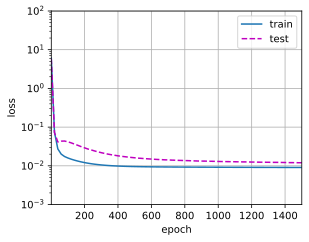

In [16]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500, wd=0)

## 2.2 权重衰退

In [52]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [53]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [54]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [55]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [56]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.47141170501709


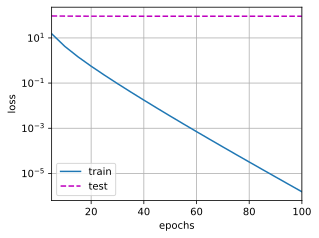

In [57]:
train(lambd=0)

w的L2范数是： 0.3415907025337219


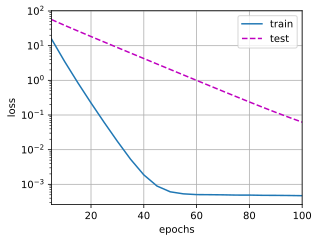

In [58]:
train(lambd=3)

In [37]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.22049617767334


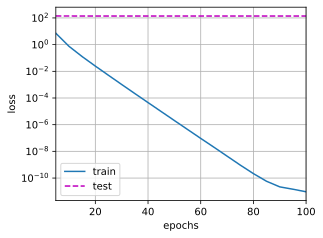

In [38]:
train_concise(0)

w的L2范数： 0.4034743010997772


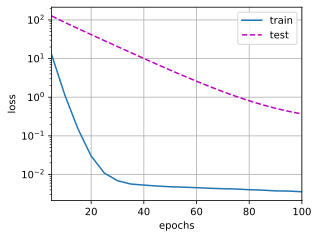

In [ ]:
train_concise(3)

## 2.3 暂退法 Dropout

In [37]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [38]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  8., 10., 12.,  0.],
        [16.,  0.,  0.,  0., 24.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [39]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0., 0.

In [40]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.is_training = is_training
        self.dense1 = nn.Linear(num_inputs, num_hiddens1)
        self.dense2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.dense3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.dense1(X.reshape((-1, self.num_inputs))))
        if self.is_training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.dense2(H1))
        if self.is_training:
            H2 = dropout_layer(H2, dropout2)
        return self.dense3(H2)
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

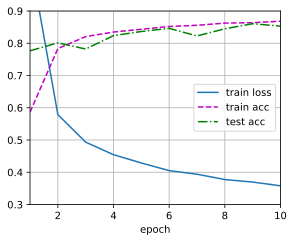

In [45]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
net.apply(init_weights)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [42]:
# 简洁实现
dropout1, dropout2 = 0.3, 0.5
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
                    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
                    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

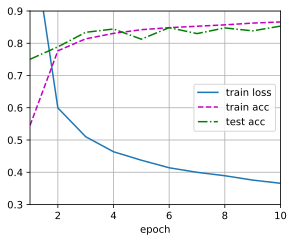

In [43]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)